In [3]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
import networkx
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiPolygon

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

The forecasts represent model predictions for where the hurricane might be at the given timestamp.

The storm track represents the true path that the storm took in the past.

In [4]:
# Forecasts
day1_forecast = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_forecasts_2024.geojson')

In [6]:
random_color = lambda: np.random.random(3)

In [5]:
# look at the forecasts
day1_forecast

,prediction,forecastHour,datetime,maxWinds,category,geometry
0,1,12,2023-08-02 08:00:00,70,1,POINT (-69.75497 37.90491)
1,1,24,2023-08-02 20:00:00,75,1,POINT (-70.50738 38.86856)
2,1,36,2023-08-03 08:00:00,85,2,POINT (-71.35866 39.41313)
3,1,48,2023-08-03 20:00:00,85,2,POINT (-71.72152 40.51758)
4,1,60,2023-08-04 08:00:00,100,3,POINT (-71.48969 41.18486)
...,...,...,...,...,...,...
155,20,48,2023-08-03 20:00:00,85,2,POINT (-71.49297 40.27587)
156,20,60,2023-08-04 08:00:00,100,3,POINT (-70.95934 42.12895)
157,20,72,2023-08-04 20:00:00,105,3,POINT (-71.61717 40.70945)
158,20,96,2023-08-05 20:00:00,90,2,POINT (-70.44554 43.65152)


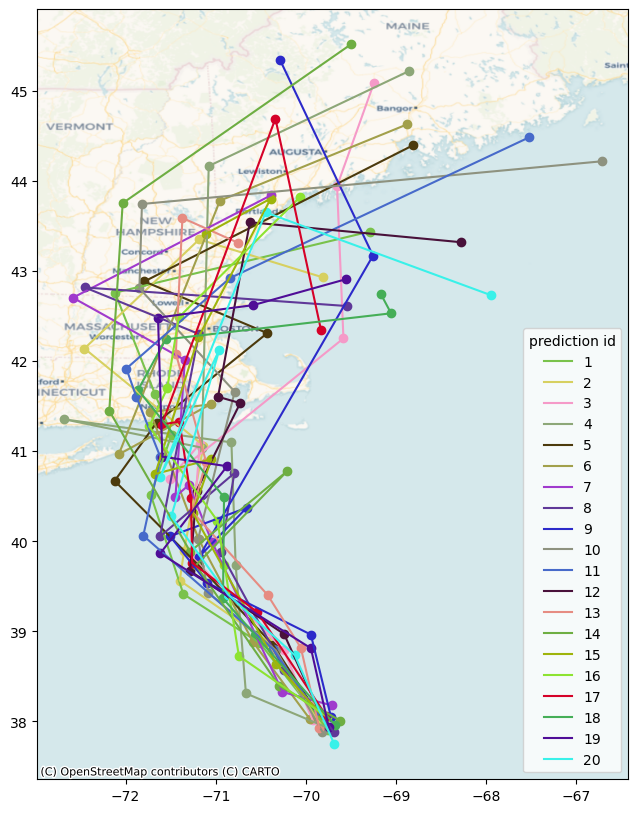

In [6]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for pred_id, pred in day1_forecast.groupby('prediction'):
    c = random_color()
    pred.plot(color=c, ax=ax)
    line_to_plot = LineString(pred.geometry.values)
    ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
ax.legend(title='prediction id')
ctx.add_basemap(ax,
               crs=day1_forecast.crs,
               source=ctx.providers.CartoDB.Voyager
              )

In [8]:
#put it in meters
day1_forecast_utm = (day1_forecast
                     .to_crs(day1_forecast.estimate_utm_crs())
                    )

day1_forecast_utm["x"] = day1_forecast_utm.geometry.x
day1_forecast_utm["y"] = day1_forecast_utm.geometry.y

day1_forecast_utm


,prediction,forecastHour,datetime,maxWinds,category,geometry,x,y
0,1,12,2023-08-02 08:00:00,70,1,POINT (433629.56 4195533.402),433629.559834,4.195533e+06
1,1,24,2023-08-02 20:00:00,75,1,POINT (369229.136 4303270.796),369229.136006,4.303271e+06
2,1,36,2023-08-03 08:00:00,85,2,POINT (296941.056 4365278.025),296941.055799,4.365278e+06
3,1,48,2023-08-03 20:00:00,85,2,POINT (269441.75 4488764.971),269441.749791,4.488765e+06
4,1,60,2023-08-04 08:00:00,100,3,POINT (291190.307 4562266.885),291190.307229,4.562267e+06
...,...,...,...,...,...,...,...,...
155,20,48,2023-08-03 20:00:00,85,2,POINT (288048.889 4461358.998),288048.889383,4.461359e+06
156,20,60,2023-08-04 08:00:00,100,3,POINT (338056.994 4665951.053),338056.994238,4.665951e+06
157,20,72,2023-08-04 20:00:00,105,3,POINT (278917.064 4509798.311),278917.063668,4.509798e+06
158,20,96,2023-08-05 20:00:00,90,2,POINT (383428.653 4834184.482),383428.653251,4.834184e+06


In [9]:
#centroids
day1_forecast_centroid_utm = (day1_forecast_utm
     .groupby('forecastHour', as_index=False)
     [['x','y']]
     .mean()
     .assign(geometry = lambda df : gpd.points_from_xy(x=df.x,y=df.y, crs=day1_forecast_utm.crs ))
    )


day1_forecast_centroid_utm

,forecastHour,x,y,geometry
0,12,431013.171246,4.205562e+06,POINT (431013.171 4205562.358)
1,24,383776.795557,4.291724e+06,POINT (383776.796 4291723.649)
2,36,316221.478205,4.399308e+06,POINT (316221.478 4399307.608)
3,48,311348.742931,4.496668e+06,POINT (311348.743 4496668.321)
4,60,297292.489615,4.551259e+06,POINT (297292.49 4551258.648)
5,72,297655.503997,4.625268e+06,POINT (297655.504 4625267.632)
6,96,337862.155698,4.801626e+06,POINT (337862.156 4801626.092)
7,120,477607.910696,4.851970e+06,POINT (477607.911 4851970.224)


In [10]:
#distances between points and centroids
dist_gdf = (day1_forecast_utm
 .merge(day1_forecast_centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(dist_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

dist_gdf


,prediction,forecastHour,datetime,maxWinds,category,geometry_orig,x,y,geometry_cent,dist_m
0,1,12,2023-08-02 08:00:00,70,1,POINT (433629.56 4195533.402),433629.559834,4.195533e+06,POINT (431013.171 4205562.358),10364.625743
1,1,24,2023-08-02 20:00:00,75,1,POINT (369229.136 4303270.796),369229.136006,4.303271e+06,POINT (383776.796 4291723.649),18573.395229
2,1,36,2023-08-03 08:00:00,85,2,POINT (296941.056 4365278.025),296941.055799,4.365278e+06,POINT (316221.478 4399307.608),39111.983164
3,1,48,2023-08-03 20:00:00,85,2,POINT (269441.75 4488764.971),269441.749791,4.488765e+06,POINT (311348.743 4496668.321),42645.738572
4,1,60,2023-08-04 08:00:00,100,3,POINT (291190.307 4562266.885),291190.307229,4.562267e+06,POINT (297292.49 4551258.648),12586.417665
...,...,...,...,...,...,...,...,...,...,...
155,20,48,2023-08-03 20:00:00,85,2,POINT (288048.889 4461358.998),288048.889383,4.461359e+06,POINT (311348.743 4496668.321),42304.036141
156,20,60,2023-08-04 08:00:00,100,3,POINT (338056.994 4665951.053),338056.994238,4.665951e+06,POINT (297292.49 4551258.648),121721.373193
157,20,72,2023-08-04 20:00:00,105,3,POINT (278917.064 4509798.311),278917.063668,4.509798e+06,POINT (297655.504 4625267.632),116979.883803
158,20,96,2023-08-05 20:00:00,90,2,POINT (383428.653 4834184.482),383428.653251,4.834184e+06,POINT (337862.156 4801626.092),56003.164841


In [11]:
radii = dist_gdf.groupby("forecastHour", as_index=False)[["dist_m"]].mean()
radii

,forecastHour,dist_m
0,12,12329.114199
1,24,26541.019450
2,36,32410.237643
3,48,48805.857816
4,60,64245.269275
5,72,79001.952104
6,96,92859.784016
7,120,129567.116892


In [12]:
#.pipe switches the grouped dataframe to a geodataframe
day1_forecast_dist_m_utm = (day1_forecast_centroid_utm.merge(radii, on="forecastHour")
                           .pipe(gpd.GeoDataFrame))
day1_forecast_dist_m_utm

,forecastHour,x,y,geometry,dist_m
0,12,431013.171246,4.205562e+06,POINT (431013.171 4205562.358),12329.114199
1,24,383776.795557,4.291724e+06,POINT (383776.796 4291723.649),26541.019450
2,36,316221.478205,4.399308e+06,POINT (316221.478 4399307.608),32410.237643
3,48,311348.742931,4.496668e+06,POINT (311348.743 4496668.321),48805.857816
4,60,297292.489615,4.551259e+06,POINT (297292.49 4551258.648),64245.269275
5,72,297655.503997,4.625268e+06,POINT (297655.504 4625267.632),79001.952104
6,96,337862.155698,4.801626e+06,POINT (337862.156 4801626.092),92859.784016
7,120,477607.910696,4.851970e+06,POINT (477607.911 4851970.224),129567.116892


In [13]:
day1_forecast_circle  = day1_forecast_dist_m_utm
day1_forecast_circle['geometry'] = day1_forecast_circle.geometry.buffer(day1_forecast_circle.dist_m)
day1_forecast_circle

,forecastHour,x,y,geometry,dist_m
0,12,431013.171246,4.205562e+06,"POLYGON ((443342.285 4205562.358, 443282.917 4...",12329.114199
1,24,383776.795557,4.291724e+06,"POLYGON ((410317.815 4291723.649, 410190.013 4...",26541.019450
2,36,316221.478205,4.399308e+06,"POLYGON ((348631.716 4399307.608, 348475.652 4...",32410.237643
3,48,311348.742931,4.496668e+06,"POLYGON ((360154.601 4496668.321, 359919.587 4...",48805.857816
4,60,297292.489615,4.551259e+06,"POLYGON ((361537.759 4551258.648, 361228.4 454...",64245.269275
5,72,297655.503997,4.625268e+06,"POLYGON ((376657.456 4625267.632, 376277.04 46...",79001.952104
6,96,337862.155698,4.801626e+06,"POLYGON ((430721.94 4801626.092, 430274.794 47...",92859.784016
7,120,477607.910696,4.851970e+06,"POLYGON ((607175.028 4851970.224, 606551.127 4...",129567.116892


In [14]:
day1_forecast_circle.area

0    4.767775e+08
1    2.209465e+09
2    3.294704e+09
3    7.471295e+09
4    1.294596e+10
5    1.957617e+10
6    2.704627e+10
7    5.265524e+10
dtype: float64

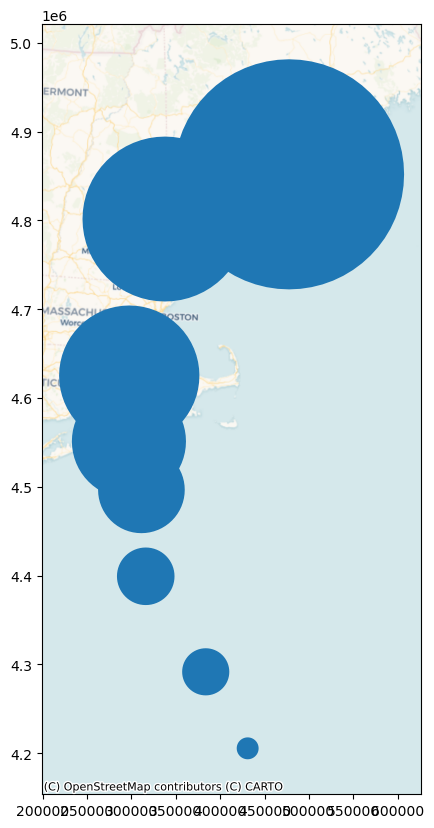

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

day1_forecast_circle.plot(ax=ax)

ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

In [16]:
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

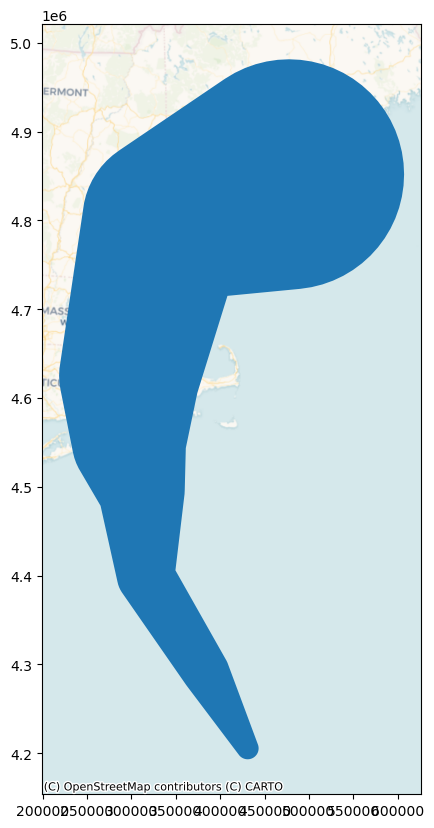

In [17]:
cone = visualizeUncertainty(day1_forecast_circle)
fig, ax = plt.subplots(1, 1, figsize=(20,10))

p = gpd.GeoSeries(cone)
p.plot(ax=ax, )


ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()


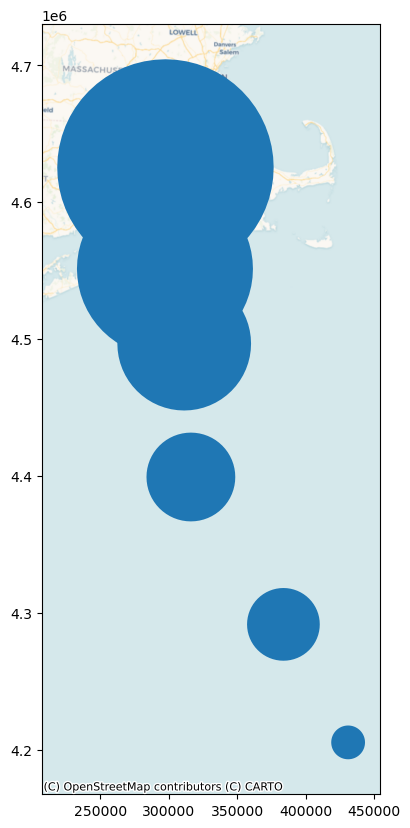

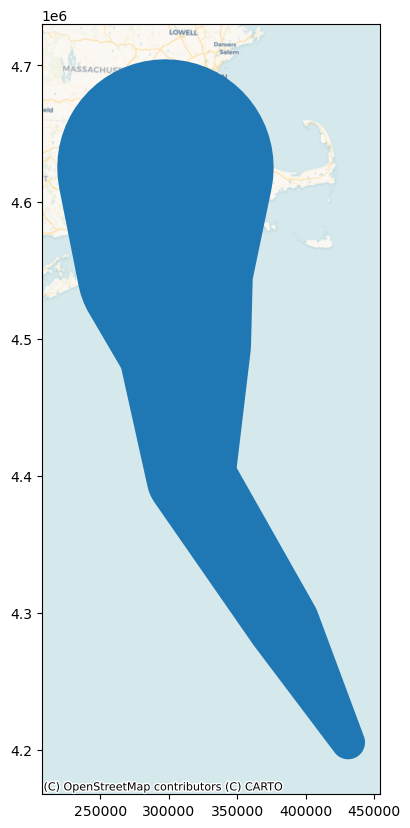

In [18]:
day1_forecast_circle_partial = day1_forecast_circle.iloc[:6,:]
fig, ax = plt.subplots(1, 1, figsize=(10,10))

day1_forecast_circle_partial.plot(ax=ax)

ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

cone = visualizeUncertainty(day1_forecast_circle_partial)
fig, ax = plt.subplots(1, 1, figsize=(20,10))

p = gpd.GeoSeries(cone)
p.plot(ax=ax, )


ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()



In [23]:
# Retrieve the population density dataset
pop_dataset = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Count").first()
pop_raster = pop_dataset.select("population_count")

# Define visualization parameters with a new color palette
viz = {
    "min": 0.0,
    "max": 1000.0,
    "palette": ["#f7fcf0", "#e0f3f8", "#bfd3c1", "#f4a582", "#d73027"]
}

# Create an interactive map
Map = geemap.Map(center=[42.407, -71.384], zoom=5)
Map.addLayer(pop_raster, viz, "Population Density")

# Display the map
Map

Map(center=[42.407, -71.384], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

Original profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 13353, 'height': 6297, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00833333330000749, 0.0, -178.23333334,
       0.0, -0.00833333329998412, 71.383332688), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
Updated profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 13353, 'height': 6297, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00833333330000749, 0.0, -178.23333334,
       0.0, -0.00833333329998412, 71.383332688), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


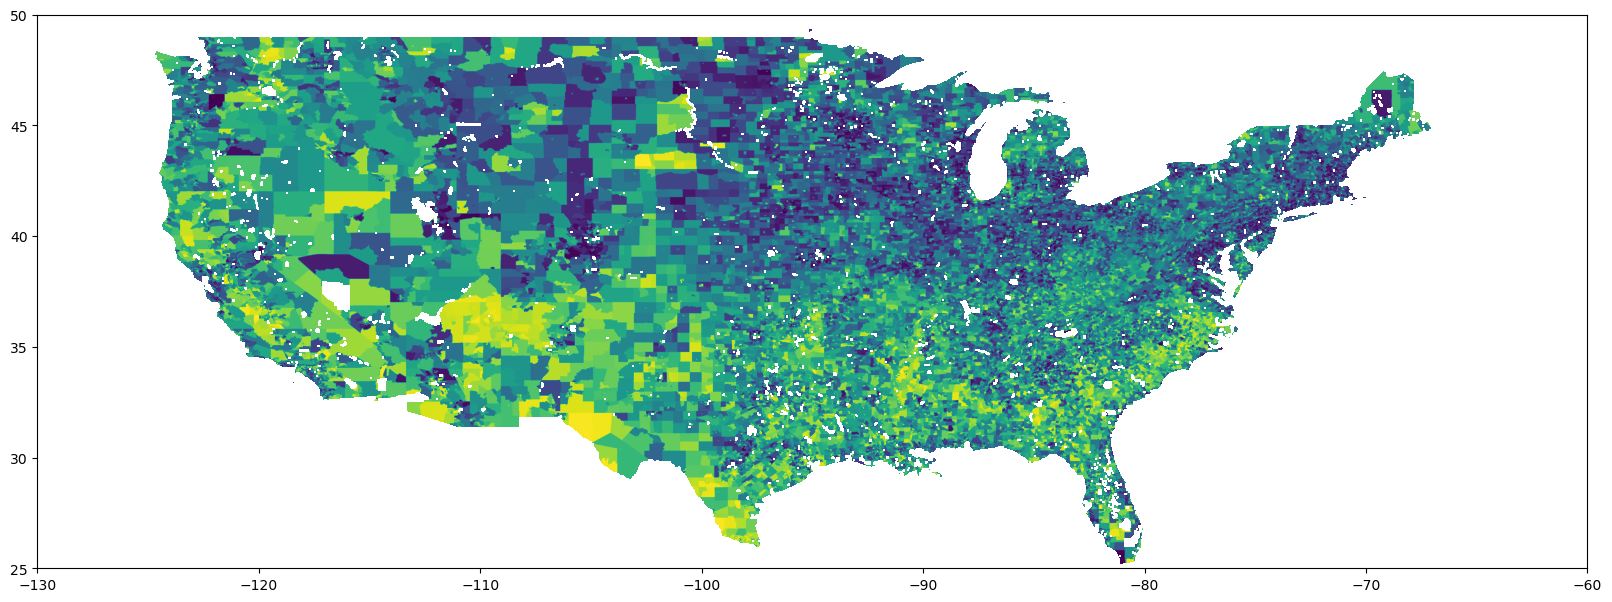

In [37]:
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt

SVI_tile = 'svi_2020_tract_overall_wgs84.tif'

def resize_tile(tile_location, rescaling_factor):
    with rasterio.open(tile_location) as src:
        print(f'Original profile: {src.profile}')
        
        new_height = int(src.height * rescaling_factor)  
        new_width = int(src.width * rescaling_factor)
        
        tile = src.read(1, out_shape=(new_height, new_width), 
                        resampling=rasterio.enums.Resampling.bilinear)
        
        tile_profile = src.profile.copy()  
        tile_profile['transform'] = src.transform * src.transform.scale(
            (src.width / tile.shape[-1]),
            (src.height / tile.shape[-2])
        )
        tile_profile['height'] = new_height
        tile_profile['width'] = new_width
        
        print(f'Updated profile: {tile_profile}')
        return tile, tile_profile

rescaling_factor = 1  

tile1, tile1_profile = resize_tile(SVI_tile, rescaling_factor)

tile1_profile['driver'] = 'GTiff'
lowres_tile1_loc = 'lowres_tile1.tif'
with rasterio.open(lowres_tile1_loc, 'w', **tile1_profile) as outfile:
    outfile.write(tile1, 1)  # Write the data to the new file

with rasterio.open(lowres_tile1_loc) as src:
    tile1_mask = src.read_masks(1)  # Read the mask
    tile1 = src.read(1)  # Read the resized image

fig = plt.figure(figsize=[20, 20])
ax1 = fig.add_subplot(2, 1, 1)
rasterio.plot.show(np.ma.masked_where(tile1_mask == 0, tile1), ax=ax1, transform=tile1_profile['transform'])
ax1.set_xlim(-130,-60 )
ax1.set_ylim(25,50)

plt.show()


In [38]:

pop_dataset = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Count").first()
pop_raster = pop_dataset.select("population_count")

viz_pop = {
    "min": 0.0,
    "max": 1000.0,
    "palette": ["#f7fcf0", "#e0f3f8", "#bfd3c1", "#f4a582", "#d73027"]
}

image1 = ee.Image('projects/geometric-edge-428819-k5/assets/svi_2020_tract_overall_wgs84')

viz_svi = {
    "min": 0.0,  
    "max": 1.0,  
    "palette": ['blue', 'green', 'yellow', 'purple']  
}

Map = geemap.Map(center=[42.407, -71.384], zoom=5)

Map.addLayer(pop_raster, viz_pop, "Population Density")

Map.addLayer(image1, viz_svi, 'SVI Data')

Map


Map(center=[42.407, -71.384], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [40]:
import shapely.geometry
from pyproj import Transformer
import ee
import geemap


ee.Initialize()


# Assuming the UTM zone is 33N. Replace '33N' with the appropriate UTM zone for your data.
transformer = Transformer.from_crs("epsg:26919", "epsg:4326", always_xy=True)

# Reproject the UTM polygon to WGS84.
cone2 = shapely.ops.transform(transformer.transform, cone)

# Convert Shapely polygon to GeoJSON format.
geojson = shapely.geometry.mapping(cone2)

# Load the GeoJSON into GEE as a feature.
cone_GEE = ee.Feature(geojson)

# Remove misclassified pixels in areas with slopes greater than 5%
srtm = ee.Image('USGS/SRTMGL1_003')
terrain = ee.Algorithms.Terrain(srtm)
slope = terrain.select('slope')


# Load the GeoTIFF as an Earth Engine Image
#coastline = ee.FeatureCollection('projects/ee-amricheatef-example2/assets/costline/tl_2019_us_coastline')

# Define visualization parameters with min and max values
vis_params = {
    'min': -25,      
    'max': 700   
}

slope_vis = {
    'min': 0,          
    'max': 30,        
    'palette': "GnBu"  
}

# If you want to visualize the feature, you can use geemap.
Map = geemap.Map()
Map.addLayer(srtm, vis_params, 'srtm')
Map.addLayer(slope, slope_vis, 'slope')
Map.addLayer(cone_GEE, {}, 'Cone day 1')
#Map.addLayer(coastline, {}, 'coastline')
Map.addLayer(pop_raster, viz, "Population Density")
Map.addLayer(image1, viz_svi, 'SVI Data')


Map.centerObject(cone_GEE, 10)
Map

Map(center=[40.65396823011885, -71.15131317312112], controls=(WidgetControl(options=['position', 'transparent_…

In [42]:
population_count = ee.Image('JRC/GHSL/P2016/POP_GPW_GLOBE_V1/2015')

population_clipped = population_count.clip(cone_GEE.geometry()).updateMask(population_count)

stats = population_clipped.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=cone_GEE.geometry(),
    scale=250,  
    maxPixels=1e9
)

number_pop_inside_cone = stats.getNumber('population_count').round()

print(f'Calculation result --> Estimated population inside the cone:\n{number_pop_inside_cone.getInfo()}')

Calculation result --> Estimated population inside the cone:
5351917


# track shows where the storm actually went in the past
day1_track = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_track_past.geojson')
day1_track.plot()

# Location of Areas of Interest


In [11]:
!wget https://files.bwsi-remote-sensing.net/data/final/R1-Hospitals.zip -O R1-Hospitals.zip
!unzip R1-Hospitals.zip

--2024-07-30 18:42:34--  https://files.bwsi-remote-sensing.net/data/final/R1-Hospitals.zip
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 35.82.230.83, 44.239.244.82, 44.240.16.119, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|35.82.230.83|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-07-30 18:42:35 ERROR 404: Not Found.

Archive:  R1-Hospitals.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of R1-Hospitals.zip or
        R1-Hospitals.zip.zip, and cannot find R1-Hospitals.zip.ZIP, period.


In [12]:
!wget https://files.bwsi-remote-sensing.net/data/final/R1-Shelters.zip -O R1-Shelters.zip
!unzip R1-Shelters.zip

--2024-07-30 18:42:38--  https://files.bwsi-remote-sensing.net/data/final/R1-Shelters.zip
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 44.240.16.119, 35.82.230.83, 52.39.175.7, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|44.240.16.119|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-07-30 18:42:38 ERROR 404: Not Found.

Archive:  R1-Shelters.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of R1-Shelters.zip or
        R1-Shelters.zip.zip, and cannot find R1-Shelters.zip.ZIP, period.


In [67]:
!pip install fiona

  Using cached fiona-1.9.6-cp311-cp311-manylinux2014_x86_64.whl.metadata (50 kB)
Using cached fiona-1.9.6-cp311-cp311-manylinux2014_x86_64.whl (15.7 MB)


In [135]:
import rasterio
import rasterio.plot
import rasterio.merge 
import rasterio.mask
import pyproj
import osmnx as ox
import geopandas as gpd
import pandas as pd
# !pip install fiona
import fiona
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [136]:
#Flood Depth Map, Getting ELevation:
local_tile1_71 = 'n42_w071_1arc_v3.tif'
local_tile2_72 = 'n42_w072_1arc_v3.tif'

In [137]:
def resize_tile(tile_location, rescaling_factor):
    with rasterio.open(tile_location) as src:
        # print profile for reference
        print(f'original profile {src.profile}')
        # calculate new dimensions
        new_height = int(src.height*rescaling_factor) # int() to round to nearest pixel
        new_width = int(src.width*rescaling_factor)
        # pass in new dimensions to out_shape, specify bilinear sampling
        tile = src.read(1, out_shape=(new_height, new_width), 
                       resampling=rasterio.enums.Resampling.bilinear)
        # copy metadata
        tile_profile = src.profile
        # update transform, height, and width entries
        tile_profile['transform'] = src.transform * src.transform.scale((src.width/tile.shape[-1]),
                                                            (src.height/tile.shape[-2]))
        tile_profile['height'] = new_height
        tile_profile['width'] = new_width
        print(f'updated profile {tile_profile}')
        return tile, tile_profile

In [138]:
rescaling_factor = 1
tile1, tile1_profile = resize_tile(local_tile1_71, rescaling_factor)
tile2, tile2_profile = resize_tile(local_tile2_72, rescaling_factor)

tile1_profile['driver'] = 'GTiff'
tile2_profile['driver'] = 'GTiff'
lowres_tile1_loc = 'lowres_tile1.tif' #WHAT IS THis?
lowres_tile2_loc = 'lowres_tile2.tif'
with rasterio.open(lowres_tile1_loc, 'w', **tile1_profile) as outfile:
    outfile.write(tile1, 1)
with rasterio.open(lowres_tile2_loc, 'w', **tile2_profile) as outfile:
    outfile.write(tile2, 1)
print(tile1.shape, tile2.shape)

original profile {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -71.00013888888888,
       0.0, -0.0002777777777777778, 43.000138888888884), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
updated profile {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -71.00013888888888,
       0.0, -0.0002777777777777778, 43.000138888888884), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
original profile {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -72.00013888888888,
       0.0, -0.0002777777777777778, 43.000138888888884), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
updated profile {'drive

In [139]:
rescaling_factor = 1
tile1, tile1_profile = resize_tile(local_tile1_71, rescaling_factor)
tile2, tile2_profile = resize_tile(local_tile2_72, rescaling_factor)

tile1_profile['driver'] = 'GTiff'
tile2_profile['driver'] = 'GTiff'
lowres_tile1_loc = 'lowres_tile1.tif' #WHAT IS THis?
lowres_tile2_loc = 'lowres_tile2.tif'
with rasterio.open(lowres_tile1_loc, 'w', **tile1_profile) as outfile:
    outfile.write(tile1, 1)
with rasterio.open(lowres_tile2_loc, 'w', **tile2_profile) as outfile:
    outfile.write(tile2, 1)
print(tile1.shape, tile2.shape)

original profile {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -71.00013888888888,
       0.0, -0.0002777777777777778, 43.000138888888884), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
updated profile {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -71.00013888888888,
       0.0, -0.0002777777777777778, 43.000138888888884), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
original profile {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -72.00013888888888,
       0.0, -0.0002777777777777778, 43.000138888888884), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
updated profile {'drive

<Axes: >

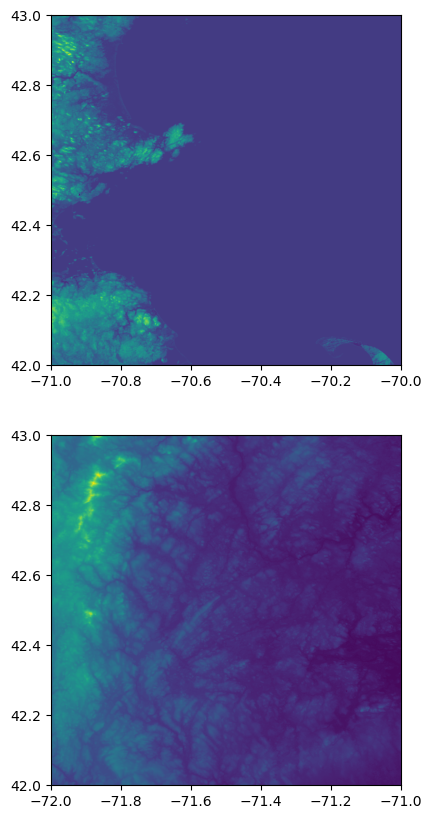

In [140]:
with rasterio.open(lowres_tile1_loc) as src:
    tile1_mask = src.read_masks(1)

with rasterio.open(lowres_tile2_loc) as src:
    tile2_mask = src.read_masks(1)

# we use the np.ma.masked_where() function to mask out all the values equal to zero
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(2,1,1)
rasterio.plot.show(np.ma.masked_where(tile1_mask==0, tile1), ax=ax1, transform=tile1_profile['transform'])
ax2 = fig.add_subplot(2,1,2)
rasterio.plot.show(np.ma.masked_where(tile2_mask==0, tile2), ax=ax2, transform=tile2_profile['transform'])

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 7201, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -72.00013888888888,
       0.0, -0.0002777777777777778, 43.000138888888884)}


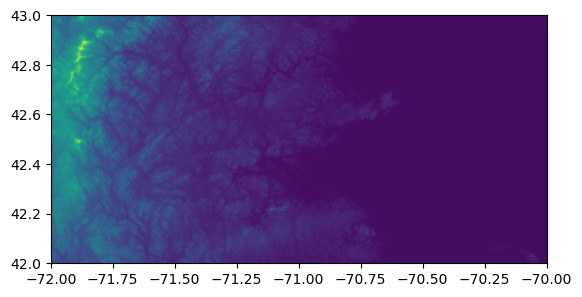

In [141]:
combined_location = 'combined.tif'
with rasterio.open(lowres_tile1_loc, 'r') as src1:
    with rasterio.open(lowres_tile2_loc, 'r') as src2:
        combined, out_transform = rasterio.merge.merge([src1, src2],
                                                       nodata=src2.profile['nodata'])
        combined_meta = src1.profile.copy()
        combined_meta.update({'driver':'GTiff',
                         'count': combined.shape[0],
                        'height': combined.shape[1],
                        'width': combined.shape[2],
                        'transform': out_transform,
                        'crs': src1.crs})
    with rasterio.open(combined_location, 'w', **combined_meta) as dst:
        dst.write(combined) #Write data set to new file
#__________________________________________________________________________________________________

with rasterio.open(combined_location, 'r') as src:
    print(src.meta)
    combined = src.read(1)
    combined_mask = src.read_masks(1)
    combined_transform = src.profile['transform']
    rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                     transform=combined_transform)



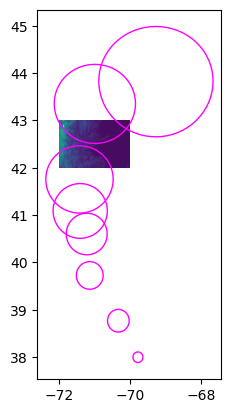

{'OpenStreetMap': {'Mapnik': {'url': 'https://tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'MapTilesAPI': {'OSMEnglish': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'en/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMEnglish'},
  'OSMFrancais': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'fr/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMFrancais'},
  'OSMEspagnol': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'es/map/v1',
   'apikey': '<insert 

In [166]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
p = rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                       ax=ax, transform=combined_transform)
day1_forecast_circle.to_crs(epsg=4326).plot(ax=ax, facecolor='none', edgecolor='magenta')

# ctx.add_basemap(ax,
#                crs=day1_forecast_circle.crs,
#                source=ctx.providers.USGS.USImagery
#               )


plt.show()

ctx.providers

<Axes: >

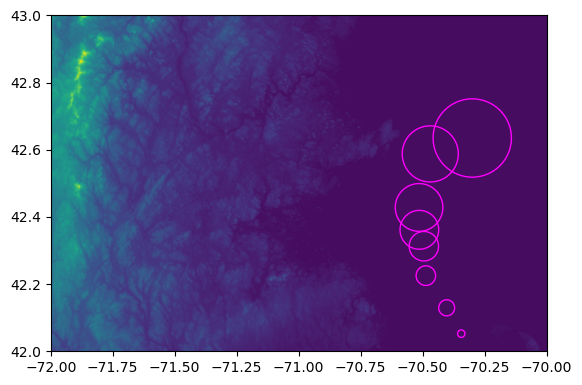

In [165]:
new_cone = MultiPolygon([day1_forecast_circle.geometry[0], day1_forecast_circle.geometry[1]\
              ,day1_forecast_circle.geometry[3],day1_forecast_circle.geometry[4],
              day1_forecast_circle.geometry[5], day1_forecast_circle.geometry[6],\
              day1_forecast_circle.geometry[7],day1_forecast_circle.geometry[2]])

from shapely.affinity import scale
from shapely.geometry import MultiPolygon
scaled_cone= scale(new_cone, xfact=.1, yfact=.1, origin= cone.centroid)

scaled_gdf = gpd.GeoDataFrame([scaled_cone], columns=['geometry'], crs =day1_forecast_circle.crs )

#Storm Surge Height:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
p = rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                       ax=ax, transform=combined_transform)
scaled_gdf.to_crs(epsg=4326).plot(ax=ax, facecolor='none', edgecolor='magenta')